# Methylation and Deamination Estimators Simulation : Liran vs. Us

Author: lee.carlin@mail.huji.ac.il  
Date: 2020-04-18  
Last edited: 2020-04-22 

To Do :  
* Find second derivative --> DONE
* Add variance simulations  - comparing the simple model to full  --> Done
* Compare my model to Liran's using complex data  ---> Done (but results not as expected...)
* Is Liran's model using complex data has a bias?   ---> It depends...

In [1]:
# libraries:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, newton
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.optimize import fsolve, newton
import scipy.stats as stats  
import time
import statistics

# Second Order Condition:
def SOC_binom(ti,pi, m_i, n_i):
    return -(t_i/(m_i**2)).sum()-(((n_i-t_i)*(pi**2))/(1-pi*m_i)**2).sum()

 
# MLE with no constant:
def square(list):
    return map(lambda x: x ** 2, list)

# MLE with  constant:
def FOC_zero(M_i,n_i,pi_i,pi_i_zero):    
    A = ((t_i*pi_i)/(pi_i_zero+pi_i*M_i)).sum()
    oneMinusT = np.array([1]*n_i)-np.array(t_i)
    oneMinusTheta = np.array([1]*n_i)-pi_i_zero-pi_i*M_i
    B = ((oneMinusT*pi_i)/(oneMinusTheta)).sum()
    return (A-B)

def SOC_zero(M_i,n_i,pi_i,pi_i_zero):    
    A = ((t_i*(pi_i**2))/(pi_i_zero+pi_i*M_i)**2).sum()
    oneMinusT = np.array([1]*n_i)-np.array(t_i)
    oneMinusTheta = np.array([1]*n_i)-pi_i_zero-pi_i*M_i
    B = ((oneMinusT*(pi_i**2))/(oneMinusTheta)**2).sum()
    return (-A-B)

# Simulating Complex Data:

Using a position depended Binomial model $t_{i,j} \sim Bern(\theta_{i,j})$   
for  $\theta$ such that  $\quad \theta_{i,j} = \pi_{i,j}^0  +m_i \times\pi^1_{i,j}$  
where $\pi_{i,j}^0$ and $\pi_{i,j}^1$ from a Gamma distribution (see below),  
simulate a vector of $t_i$ for $i \in [1,2,\dots,N]$ and estimate using Liran's and our models:

In [2]:
# Parameters:
# General:

sample_len = 1000 # "DNA" sample length-> N
coverage = 30 # (n_i) - fixed here
m_i =  0.7 

# Parameters for complex model:

m_i_initial_guess = 0.5 # for complex model
# pi_i simulation: # suggested distribution form (gamma):
# Coefficient:
shape =  1
scale =  0.1  
# For gamma, Inverse scale (1/scale) is rate parameter.
rate = 1/scale
mean_gamma = shape/rate
print('Mean of gamma: {:,}'.format(mean_gamma))
# Constant:
shape_zero =  0.5
scale_zero =  0.1 
rate_zero = 1/scale_zero
mean_gamma_zero = shape_zero/rate_zero
print('Mean of gamma zero: {:,}'.format(mean_gamma_zero))

Mean of gamma: 0.1
Mean of gamma zero: 0.05


In [3]:
mean_gamma_zero+mean_gamma*m_i

0.12

In [5]:
# Simulating Data:
data = []

est_simple_list = []
sd_simple_list = []

est_complex_list = []
sd_scomplex_list = []

rng = range(0,sample_len)
for i in rng:
    pi_i = np.random.gamma(shape, scale, coverage)
    pi_i_zero = np.random.gamma(shape_zero, scale_zero, coverage)
    theta = pi_i_zero+pi_i*m_i
    theta[theta>0.99]=0.99
    t_i = np.random.binomial(1,theta)
    
    # Estimating m_i using simple model:
    #pi = np.mean(pi_i)
    pi = mean_gamma_zero+mean_gamma #(FIXED pi)
    solution_simple = t_i.sum()/(coverage*pi) #MLE: m_i = t_i/(pi*n_i)
    solution_simple = 0 if solution_simple<0 else solution_simple #ignore zero values
    est_simple_list.append(solution_simple)
    sd_simple_list.append(1/(-SOC_binom(t_i,pi, solution_simple, coverage)))
    
    # Estimating m_i using complex model: 
    solution = fsolve(FOC_zero, m_i_initial_guess,args=(coverage,pi_i,pi_i_zero))[0]
    #solution = sp.optimize.newton(FOC_zero, m_i_initial_guess,args=(coverage,pi_i,pi_i_zero))
    #solution = sp.optimize.brentq(FOC_zero,a = 1e-80, b = 1-1e-80,args=(coverage,pi_i,pi_i_zero))
    solution = 0 if solution<0 else solution #ignore zero values
    est_complex_list.append(solution)
    sd_scomplex_list.append(1/(-SOC_zero(solution,coverage,pi_i,pi_i_zero)))
    data.append(t_i)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


In [6]:
print('The mean of the simple model estimation: {:,}'.format(np.array(est_simple_list).mean()))
print('The mean of the complex model estimation: {:,}'.format(np.array(est_complex_list).mean()))
print('The std of the simple model estimation: {:,}'.format(np.array(est_simple_list).std()))
print('The std of the complex model estimation: {:,}'.format(np.array(est_complex_list).std()))

The mean of the simple model estimation: 0.8079999999999997
The mean of the complex model estimation: 0.7237217495036629
The std of the simple model estimation: 0.40767355616358253
The std of the complex model estimation: 0.5339252696909176


In [22]:
print('The mean of the simple model sd : {:,}'.format(np.array(sd_simple_list)[~np.isnan(sd_simple_list)].mean()))
print('The mean of the complex model sd: {:,}'.format(np.array(sd_scomplex_list).mean()))

The mean of the simple model sd : 0.029636922131890307
The mean of the complex model sd: 0.3767066695705071


In [23]:
bounded_simple = np.array(est_simple_list)
bounded_simple[bounded_simple > 1] = 0
bounded_complex = np.array(est_complex_list)
bounded_complex[bounded_complex > 1] = 0


print('The std of the simple bounded model estimation: {:,}'.format(bounded_simple.std()))
print('The std of the complex bounded model estimation: {:,}'.format(bounded_complex.std()))

The std of the simple bounded model estimation: 0.34078884523563413
The std of the complex bounded model estimation: 0.33554918348866175


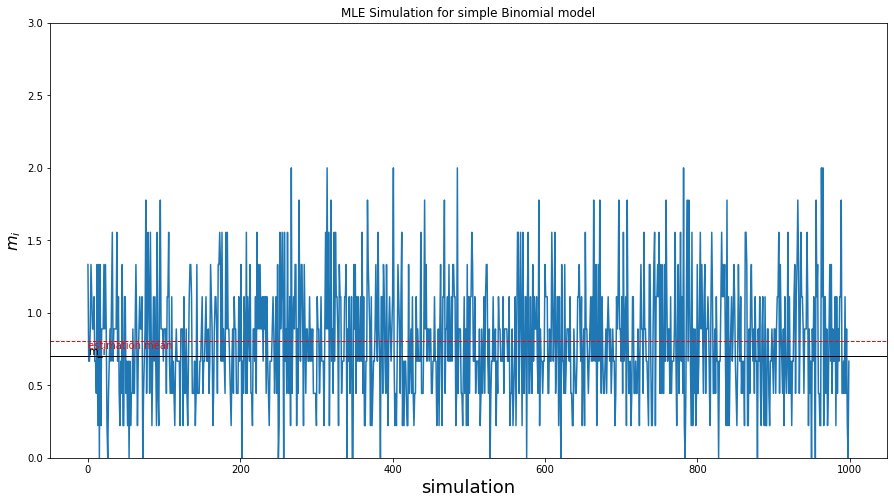

In [8]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(rng,est_simple_list)
ax.axhline(y=m_i, color = 'black', ls='-',lw=1)
ax.axhline(y=np.array(est_simple_list).mean(), color = 'red', ls='--',lw=1)
ax.text(x=0,y= m_i, s= 'm_i', color = 'black',verticalalignment='bottom')
ax.text(x=0,y= np.array(est_simple_list).mean(), s= 'estimation mean', color = 'red',verticalalignment='top')
ax.set_title('MLE Simulation for simple Binomial model')
plt.xlabel('simulation', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
plt.ylim([0,3])
plt.show()


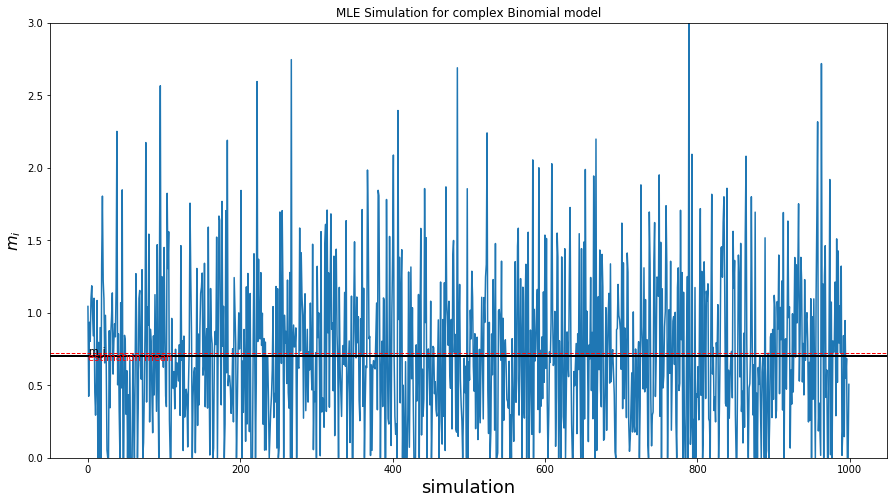

In [9]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(rng,est_complex_list)
ax.axhline(y=m_i, color = 'black', ls='-',lw=2)
ax.axhline(y=np.array(est_complex_list).mean(), color = 'red', ls='--',lw=1)
ax.text(x=0,y= m_i, s= 'm_i', color = 'black',verticalalignment='bottom')
ax.text(x=0,y= np.array(est_complex_list).mean(), s= 'estimation mean', color = 'red',verticalalignment='top')
ax.set_title('MLE Simulation for complex Binomial model')
plt.xlabel('simulation', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
plt.ylim([0,3])
plt.show()
